# Predicting Label Costs with Regression

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Cleaning the Data: The Roadmap after Several Rounds of EDA (in separate notebooks)

Drops:
* MATERIAL_DESCRIPTION (string version of SKU contained in MATERIAL_NO)
* ITEM_DESCRIPTION (code version of all data contained in other columns)
* UOM (unit of measure) drop it for now, we can return to them if the predictions are poor (**CHOICE**)
* QTY_PER_UOM (quantity per unit of measure) same here (**CHOICE**)

Wrong datatypes:
* INVOICE_DATE: needs to be datetime and transformed into features
* DOW: new feature created from invoice dates, needs to be dummified
* ITEM: needs to be int, then dummified as categorical data (**CHOICE**)
* MATERIAL_NO: needs to be int, drop NC (not configured) and purchased, then dummified as categorical data
* SHAPE: needs to be lowercased, then dummified

Transformations:
* need to convert (WIDTH + WIDTH_UNIT) (LENGTH + LENGTH_UNIT) & (VERTICAL_GAP) into some common number in mm
* turn Nans into 0 in WIDTH, LENGTH, DIAMETER

Outliers (measurements):
* WIDTH, LENGTH, VERTICAL_GAP: no negative values, zero is dependent on shape. 
* unusually high values were left in the dataset and may be pulling the regression line up (**CHOICE**)
* DIAMETER: needs to be under 10 mm, drop the 6 outliers in the 20 - 92 mm range

Outliers (items related to sales):
* UNITS_SOLD: drop 4,851 minus amounts
* UNIT_PRICE: drop 4 minus prices, 16,434 zero prices
* UNIT_COST: 115 zero costs
* unusually high values were left in the dataset and may be pulling the regression line up (**CHOICE**)

Outliers (misc. items):
* NO_ACROSS: What is NO_ACROSS? In NO_ACROSS, most values are 1.0, vast majority are under 6.0, but there are 14 outliers between 8.0 and 11.0. Are those normal data points or should they be dropped?

Missing values:
* ITEM (470), SHAPE (440), NO_ACROSS (440): dropped them
* VERT_GAP_NEW (5559): since vertical gap is only associated with certain shapes, I filled missing items with zero

In [2]:
# when reading in, set dtype for wrong data types except for datetime
my_dict = {'ITEM': np.int64, 'MATERIAL_NO': np.int64}
sample = pd.read_excel('data/labels-regression-data.xlsx', dtypes=my_dict)
sample.head()

,INVOICE_DATE,ITEM,ITEM_DESCRIPTION,UNITS_SOLD,UNIT_PRICE,UNIT_COST,MATERIAL_NO,MATERIAL_DESCRIPTION,LENGTH,LENGTH_UNITS,WIDTH,WIDTH_UNITS,SHAPE,DIAMETER,VERTICAL_GAP,NO_ACROSS,UOM,QTY_PER_UOM
0,10/07/2015,16001011,L 3.875X3 167 .75K6,6,38.85,15.0455,0167,DYE INKJET GLOSS WHITE PAPER with PERMANENT ad...,3.0,"""",3.875,"""",Rectangle,NaN,".125""",1.0,RL,750
1,10/07/2015,16001011,L 3.875X3 167 .75K6,6,38.85,15.0455,0167,DYE INKJET GLOSS WHITE PAPER with PERMANENT ad...,3.0,"""",3.875,"""",Rectangle,NaN,".125""",1.0,RL,750
2,01/18/2016,16001011,L 3.875X3 167 .75K6,6,38.85,15.0455,0167,DYE INKJET GLOSS WHITE PAPER with PERMANENT ad...,3.0,"""",3.875,"""",Rectangle,NaN,".125""",1.0,RL,750
3,01/18/2016,16001011,L 3.875X3 167 .75K6,6,38.85,15.0455,0167,DYE INKJET GLOSS WHITE PAPER with PERMANENT ad...,3.0,"""",3.875,"""",Rectangle,NaN,".125""",1.0,RL,750
4,04/29/2016,16001011,L 3.875X3 167 .75K6,14,38.85,14.5266,0167,DYE INKJET GLOSS WHITE PAPER with PERMANENT ad...,3.0,"""",3.875,"""",Rectangle,NaN,".125""",1.0,RL,750


In [3]:
# inspect dataframe
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222904 entries, 0 to 222903
Data columns (total 18 columns):
INVOICE_DATE            222904 non-null object
ITEM                    222904 non-null object
ITEM_DESCRIPTION        222904 non-null object
UNITS_SOLD              222904 non-null int64
UNIT_PRICE              222904 non-null float64
UNIT_COST               222904 non-null float64
MATERIAL_NO             222862 non-null object
MATERIAL_DESCRIPTION    222859 non-null object
LENGTH                  211377 non-null float64
LENGTH_UNITS            211193 non-null object
WIDTH                   211839 non-null float64
WIDTH_UNITS             211837 non-null object
SHAPE                   222400 non-null object
DIAMETER                11023 non-null float64
VERTICAL_GAP            220670 non-null object
NO_ACROSS               222400 non-null float64
UOM                     222870 non-null object
QTY_PER_UOM             222904 non-null int64
dtypes: float64(6), int64(2), object(10)

### Drops

In [4]:
# drop ITEM_DESCRIPTION, MATERIAL_DESCRIPTION
sample.drop(labels=['ITEM_DESCRIPTION', 'MATERIAL_DESCRIPTION'], axis=1, inplace=True)
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222904 entries, 0 to 222903
Data columns (total 16 columns):
INVOICE_DATE    222904 non-null object
ITEM            222904 non-null object
UNITS_SOLD      222904 non-null int64
UNIT_PRICE      222904 non-null float64
UNIT_COST       222904 non-null float64
MATERIAL_NO     222862 non-null object
LENGTH          211377 non-null float64
LENGTH_UNITS    211193 non-null object
WIDTH           211839 non-null float64
WIDTH_UNITS     211837 non-null object
SHAPE           222400 non-null object
DIAMETER        11023 non-null float64
VERTICAL_GAP    220670 non-null object
NO_ACROSS       222400 non-null float64
UOM             222870 non-null object
QTY_PER_UOM     222904 non-null int64
dtypes: float64(6), int64(2), object(8)
memory usage: 27.2+ MB


In [5]:
# CHOICE: for now, drop UOM, QTY_PER_UOM
sample.drop(labels=['UOM', 'QTY_PER_UOM'], axis=1, inplace=True)
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222904 entries, 0 to 222903
Data columns (total 14 columns):
INVOICE_DATE    222904 non-null object
ITEM            222904 non-null object
UNITS_SOLD      222904 non-null int64
UNIT_PRICE      222904 non-null float64
UNIT_COST       222904 non-null float64
MATERIAL_NO     222862 non-null object
LENGTH          211377 non-null float64
LENGTH_UNITS    211193 non-null object
WIDTH           211839 non-null float64
WIDTH_UNITS     211837 non-null object
SHAPE           222400 non-null object
DIAMETER        11023 non-null float64
VERTICAL_GAP    220670 non-null object
NO_ACROSS       222400 non-null float64
dtypes: float64(6), int64(1), object(7)
memory usage: 23.8+ MB


### Wrong Datatypes

INVOICE_DATE

In [6]:
# convert datetime
sample.INVOICE_DATE = pd.to_datetime(sample.INVOICE_DATE, errors='coerce')
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222904 entries, 0 to 222903
Data columns (total 14 columns):
INVOICE_DATE    222904 non-null datetime64[ns]
ITEM            222904 non-null object
UNITS_SOLD      222904 non-null int64
UNIT_PRICE      222904 non-null float64
UNIT_COST       222904 non-null float64
MATERIAL_NO     222862 non-null object
LENGTH          211377 non-null float64
LENGTH_UNITS    211193 non-null object
WIDTH           211839 non-null float64
WIDTH_UNITS     211837 non-null object
SHAPE           222400 non-null object
DIAMETER        11023 non-null float64
VERTICAL_GAP    220670 non-null object
NO_ACROSS       222400 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1), object(6)
memory usage: 23.8+ MB


In [7]:
# feature transformation for datetime
# rename INVOICE_DATE column
sample['date'] = sample['INVOICE_DATE']
# turn time series into demand week, year, month, DOW
def convert_dates(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    return df
# DOW
def convert_DOW(df):
    df['DOW'] = df['date'].dt.weekday_name
    return df
sample = convert_dates(sample)
sample = convert_DOW(sample)
sample.head()

,INVOICE_DATE,ITEM,UNITS_SOLD,UNIT_PRICE,UNIT_COST,MATERIAL_NO,LENGTH,LENGTH_UNITS,WIDTH,WIDTH_UNITS,SHAPE,DIAMETER,VERTICAL_GAP,NO_ACROSS,date,year,month,day,DOW
0,2015-10-07,16001011,6,38.85,15.0455,0167,3.0,"""",3.875,"""",Rectangle,NaN,".125""",1.0,2015-10-07,2015,10,7,Wednesday
1,2015-10-07,16001011,6,38.85,15.0455,0167,3.0,"""",3.875,"""",Rectangle,NaN,".125""",1.0,2015-10-07,2015,10,7,Wednesday
2,2016-01-18,16001011,6,38.85,15.0455,0167,3.0,"""",3.875,"""",Rectangle,NaN,".125""",1.0,2016-01-18,2016,1,18,Monday
3,2016-01-18,16001011,6,38.85,15.0455,0167,3.0,"""",3.875,"""",Rectangle,NaN,".125""",1.0,2016-01-18,2016,1,18,Monday
4,2016-04-29,16001011,14,38.85,14.5266,0167,3.0,"""",3.875,"""",Rectangle,NaN,".125""",1.0,2016-04-29,2016,4,29,Friday


In [8]:
# drop INVOICE_DATE and DATE
sample.drop(labels=['INVOICE_DATE','date'], axis=1, inplace=True)
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222904 entries, 0 to 222903
Data columns (total 17 columns):
ITEM            222904 non-null object
UNITS_SOLD      222904 non-null int64
UNIT_PRICE      222904 non-null float64
UNIT_COST       222904 non-null float64
MATERIAL_NO     222862 non-null object
LENGTH          211377 non-null float64
LENGTH_UNITS    211193 non-null object
WIDTH           211839 non-null float64
WIDTH_UNITS     211837 non-null object
SHAPE           222400 non-null object
DIAMETER        11023 non-null float64
VERTICAL_GAP    220670 non-null object
NO_ACROSS       222400 non-null float64
year            222904 non-null int64
month           222904 non-null int64
day             222904 non-null int64
DOW             222904 non-null object
dtypes: float64(6), int64(4), object(7)
memory usage: 28.9+ MB


ITEM

In [9]:
# turn into integer
sample.ITEM = pd.to_numeric(sample.ITEM, errors='coerce')
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222904 entries, 0 to 222903
Data columns (total 17 columns):
ITEM            222291 non-null float64
UNITS_SOLD      222904 non-null int64
UNIT_PRICE      222904 non-null float64
UNIT_COST       222904 non-null float64
MATERIAL_NO     222862 non-null object
LENGTH          211377 non-null float64
LENGTH_UNITS    211193 non-null object
WIDTH           211839 non-null float64
WIDTH_UNITS     211837 non-null object
SHAPE           222400 non-null object
DIAMETER        11023 non-null float64
VERTICAL_GAP    220670 non-null object
NO_ACROSS       222400 non-null float64
year            222904 non-null int64
month           222904 non-null int64
day             222904 non-null int64
DOW             222904 non-null object
dtypes: float64(7), int64(4), object(6)
memory usage: 28.9+ MB


MATERIAL_NO

In [10]:
# look at unique values - few starts with NC (for "not configured') and a few are 'PURCHASED'
sample.MATERIAL_NO.unique()

array(['0167', '0158', '0063', '0043', '0119', '0106', '0160', '0002',
       nan, '0091', '0164', '0165', '13', '0009', '0117', '0001', '0129',
       '0162', '0121', '0122', '0154', '0006', '0066', '0168', '0035',
       '0163', '0024', '0064', '0052', '0003', '0055', '0112', '0025',
       '0014', '0051', '0019', '0048', '0004', '0123', '0031', '0040',
       '0116', '0026', '0011', '0069', '0010', '0172', '05', '54', '0128',
       '0087', '0021', '08', '0018', '0111', '134', '0068', '126', '0049',
       '0058', '0093', '0062', '0060', '0156', '89', '0183', '0166',
       '0169', '0178', '0188', '0190', '0198', '0200', '0202', '205',
       '0207', '0208', '0216', '0222', '0233', '242', '0135', '0061',
       '23', '110', '0012', '0077', '0075', '85', '37', '0092', '76',
       '96', 'PURCHASED', '74', 'NC0410', '0159', '0185', '0197', '0217',
       '0224', 'NC0131', '0204', '201', '0206', '0211', '214', '0215',
       '0218', '0228', '0223', '0157', '0237', '0236', '238', '0232'

In [11]:
# drop where MATERIAL_NO is 'PURCHASED'
sample = sample[sample.MATERIAL_NO != 'PURCHASED']
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222898 entries, 0 to 222903
Data columns (total 17 columns):
ITEM            222287 non-null float64
UNITS_SOLD      222898 non-null int64
UNIT_PRICE      222898 non-null float64
UNIT_COST       222898 non-null float64
MATERIAL_NO     222856 non-null object
LENGTH          211371 non-null float64
LENGTH_UNITS    211187 non-null object
WIDTH           211833 non-null float64
WIDTH_UNITS     211831 non-null object
SHAPE           222394 non-null object
DIAMETER        11023 non-null float64
VERTICAL_GAP    220666 non-null object
NO_ACROSS       222394 non-null float64
year            222898 non-null int64
month           222898 non-null int64
day             222898 non-null int64
DOW             222898 non-null object
dtypes: float64(7), int64(4), object(6)
memory usage: 30.6+ MB


In [12]:
# drop where MATERIAL_NO starts with NC  (184 instances)
sample = sample[sample.MATERIAL_NO.str.startswith('NC') == False]
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222672 entries, 0 to 222903
Data columns (total 17 columns):
ITEM            222198 non-null float64
UNITS_SOLD      222672 non-null int64
UNIT_PRICE      222672 non-null float64
UNIT_COST       222672 non-null float64
MATERIAL_NO     222672 non-null object
LENGTH          211187 non-null float64
LENGTH_UNITS    211003 non-null object
WIDTH           211649 non-null float64
WIDTH_UNITS     211647 non-null object
SHAPE           222210 non-null object
DIAMETER        11023 non-null float64
VERTICAL_GAP    220590 non-null object
NO_ACROSS       222210 non-null float64
year            222672 non-null int64
month           222672 non-null int64
day             222672 non-null int64
DOW             222672 non-null object
dtypes: float64(7), int64(4), object(6)
memory usage: 30.6+ MB


In [13]:
# turn into integer
sample.MATERIAL_NO = pd.to_numeric(sample.MATERIAL_NO, errors='coerce')
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222672 entries, 0 to 222903
Data columns (total 17 columns):
ITEM            222198 non-null float64
UNITS_SOLD      222672 non-null int64
UNIT_PRICE      222672 non-null float64
UNIT_COST       222672 non-null float64
MATERIAL_NO     222672 non-null int64
LENGTH          211187 non-null float64
LENGTH_UNITS    211003 non-null object
WIDTH           211649 non-null float64
WIDTH_UNITS     211647 non-null object
SHAPE           222210 non-null object
DIAMETER        11023 non-null float64
VERTICAL_GAP    220590 non-null object
NO_ACROSS       222210 non-null float64
year            222672 non-null int64
month           222672 non-null int64
day             222672 non-null int64
DOW             222672 non-null object
dtypes: float64(7), int64(5), object(5)
memory usage: 30.6+ MB


### Transformations

In [14]:
# fill LENGTH, WIDTH, DIAMETER, NaNs with 0 for 
sample[['LENGTH', 'WIDTH', 'DIAMETER']] = sample[['LENGTH', 'WIDTH', 'DIAMETER']].fillna(value=0)
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222672 entries, 0 to 222903
Data columns (total 17 columns):
ITEM            222198 non-null float64
UNITS_SOLD      222672 non-null int64
UNIT_PRICE      222672 non-null float64
UNIT_COST       222672 non-null float64
MATERIAL_NO     222672 non-null int64
LENGTH          222672 non-null float64
LENGTH_UNITS    211003 non-null object
WIDTH           222672 non-null float64
WIDTH_UNITS     211647 non-null object
SHAPE           222210 non-null object
DIAMETER        222672 non-null float64
VERTICAL_GAP    220590 non-null object
NO_ACROSS       222210 non-null float64
year            222672 non-null int64
month           222672 non-null int64
day             222672 non-null int64
DOW             222672 non-null object
dtypes: float64(7), int64(5), object(5)
memory usage: 30.6+ MB


In [15]:
# parse VERTICAL_GAP into VERT_GAP and VERT_GAP_UNITS
import re

sample['VERT_GAP_UNITS'] = sample['VERTICAL_GAP'].str.extract('("|mm)', expand=True, flags = re.IGNORECASE)
sample['VERT_GAP'] = sample['VERTICAL_GAP'].str.extract('(.\d+)', expand=True, flags = re.IGNORECASE)
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222672 entries, 0 to 222903
Data columns (total 19 columns):
ITEM              222198 non-null float64
UNITS_SOLD        222672 non-null int64
UNIT_PRICE        222672 non-null float64
UNIT_COST         222672 non-null float64
MATERIAL_NO       222672 non-null int64
LENGTH            222672 non-null float64
LENGTH_UNITS      211003 non-null object
WIDTH             222672 non-null float64
WIDTH_UNITS       211647 non-null object
SHAPE             222210 non-null object
DIAMETER          222672 non-null float64
VERTICAL_GAP      220590 non-null object
NO_ACROSS         222210 non-null float64
year              222672 non-null int64
month             222672 non-null int64
day               222672 non-null int64
DOW               222672 non-null object
VERT_GAP_UNITS    219511 non-null object
VERT_GAP          216713 non-null object
dtypes: float64(7), int64(5), object(7)
memory usage: 34.0+ MB


In [16]:
# change VERT_GAP to float
sample.VERT_GAP = sample.VERT_GAP.astype(float)
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222672 entries, 0 to 222903
Data columns (total 19 columns):
ITEM              222198 non-null float64
UNITS_SOLD        222672 non-null int64
UNIT_PRICE        222672 non-null float64
UNIT_COST         222672 non-null float64
MATERIAL_NO       222672 non-null int64
LENGTH            222672 non-null float64
LENGTH_UNITS      211003 non-null object
WIDTH             222672 non-null float64
WIDTH_UNITS       211647 non-null object
SHAPE             222210 non-null object
DIAMETER          222672 non-null float64
VERTICAL_GAP      220590 non-null object
NO_ACROSS         222210 non-null float64
year              222672 non-null int64
month             222672 non-null int64
day               222672 non-null int64
DOW               222672 non-null object
VERT_GAP_UNITS    219511 non-null object
VERT_GAP          216713 non-null float64
dtypes: float64(8), int64(5), object(6)
memory usage: 34.0+ MB


In [17]:
# SHAPE: first fix uppercase/lowercase
sample.SHAPE = sample.SHAPE.str.lower()
sample.SHAPE.value_counts()

rectangle        186995
circle            10925
square            10070
continuous         3744
custom             3259
oval               1712
arc                1568
multi-part         1087
notched tag         899
lip balm            548
trapezoid           387
band/jar band       352
tombstone           268
l-shape             127
doughnut             94
oblong               66
octagon              32
barbell              18
diamond              16
triangle             14
ribbon                8
heart                 6
shield                6
hexagon               4
bows/ties             2
tear drop             2
bottom cutter         1
Name: SHAPE, dtype: int64

### Outliers (measurements):

In [18]:
# fix mm, MM issue in WIDTH_UNITS, LENGTH_UNITS, VERT_GAP_UNITS
sample.WIDTH_UNITS.replace('MM', 'mm', inplace=True)
sample.LENGTH_UNITS.replace('MM', 'mm', inplace=True)
sample.VERT_GAP_UNITS.replace('MM', 'mm', inplace=True)
print(sample.VERT_GAP_UNITS.unique())
print(sample.WIDTH_UNITS.unique())
print(sample.LENGTH_UNITS.unique())

['"' nan 'mm']
['"' 'mm' nan]
['"' 'mm' nan "'" 'M']


In [19]:
# diameter - drop 6 outliers above 10mm (48 values)
sample = sample[sample.DIAMETER <=10]
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222624 entries, 0 to 222903
Data columns (total 19 columns):
ITEM              222150 non-null float64
UNITS_SOLD        222624 non-null int64
UNIT_PRICE        222624 non-null float64
UNIT_COST         222624 non-null float64
MATERIAL_NO       222624 non-null int64
LENGTH            222624 non-null float64
LENGTH_UNITS      211003 non-null object
WIDTH             222624 non-null float64
WIDTH_UNITS       211647 non-null object
SHAPE             222162 non-null object
DIAMETER          222624 non-null float64
VERTICAL_GAP      220542 non-null object
NO_ACROSS         222162 non-null float64
year              222624 non-null int64
month             222624 non-null int64
day               222624 non-null int64
DOW               222624 non-null object
VERT_GAP_UNITS    219463 non-null object
VERT_GAP          216665 non-null float64
dtypes: float64(8), int64(5), object(6)
memory usage: 34.0+ MB


In [20]:
# convert WIDTH, LENGTH, VERT_GAP
def convert_scales(row, col_unit, col):
    if row[col_unit] == 'M':
        return row[col] * 1000
    elif row[col_unit] == "'":
        return row[col] * 304.8
    elif row[col_unit] == '"':
        return row[col] * 25.4
    else:
        return row[col]

sample['WIDTH_NEW'] = sample.apply(convert_scales, col_unit='WIDTH_UNITS', col='WIDTH', axis=1)
sample['LENGTH_NEW'] = sample.apply(convert_scales, col_unit='LENGTH_UNITS', col='LENGTH', axis=1)
sample['VERT_GAP_NEW'] = sample.apply(convert_scales, col_unit='VERT_GAP_UNITS', col='VERT_GAP', axis=1)
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222624 entries, 0 to 222903
Data columns (total 22 columns):
ITEM              222150 non-null float64
UNITS_SOLD        222624 non-null int64
UNIT_PRICE        222624 non-null float64
UNIT_COST         222624 non-null float64
MATERIAL_NO       222624 non-null int64
LENGTH            222624 non-null float64
LENGTH_UNITS      211003 non-null object
WIDTH             222624 non-null float64
WIDTH_UNITS       211647 non-null object
SHAPE             222162 non-null object
DIAMETER          222624 non-null float64
VERTICAL_GAP      220542 non-null object
NO_ACROSS         222162 non-null float64
year              222624 non-null int64
month             222624 non-null int64
day               222624 non-null int64
DOW               222624 non-null object
VERT_GAP_UNITS    219463 non-null object
VERT_GAP          216665 non-null float64
WIDTH_NEW         222624 non-null float64
LENGTH_NEW        222624 non-null float64
VERT_GAP_NEW      21666

In [21]:
# drop LENGTH, LENGTH_UNITS, WIDTH, WIDTH_UNITS, VERTICAL_GAP, VERT_GAP_UNITS, VERT_GAP
sample.drop(['LENGTH', 'LENGTH_UNITS', 'WIDTH', 'WIDTH_UNITS', 'VERTICAL_GAP', 'VERT_GAP_UNITS', 'VERT_GAP'], axis=1, inplace=True)

### Outliers (items related to sales):

In [22]:
# drop minus and zero amounts
sample = sample[sample.UNITS_SOLD > 0]
sample = sample[sample.UNIT_PRICE > 0]
sample = sample[sample.UNIT_COST > 0]

### Missing values

In [23]:
# inspect remainder missing values
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201392 entries, 0 to 222903
Data columns (total 15 columns):
ITEM            200922 non-null float64
UNITS_SOLD      201392 non-null int64
UNIT_PRICE      201392 non-null float64
UNIT_COST       201392 non-null float64
MATERIAL_NO     201392 non-null int64
SHAPE           200952 non-null object
DIAMETER        201392 non-null float64
NO_ACROSS       200952 non-null float64
year            201392 non-null int64
month           201392 non-null int64
day             201392 non-null int64
DOW             201392 non-null object
WIDTH_NEW       201392 non-null float64
LENGTH_NEW      201392 non-null float64
VERT_GAP_NEW    195833 non-null float64
dtypes: float64(8), int64(5), object(2)
memory usage: 24.6+ MB


In [24]:
# and fill VERT_GAP_NEW with 0
sample['VERT_GAP_NEW'] = sample['VERT_GAP_NEW'].fillna(value=0)
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201392 entries, 0 to 222903
Data columns (total 15 columns):
ITEM            200922 non-null float64
UNITS_SOLD      201392 non-null int64
UNIT_PRICE      201392 non-null float64
UNIT_COST       201392 non-null float64
MATERIAL_NO     201392 non-null int64
SHAPE           200952 non-null object
DIAMETER        201392 non-null float64
NO_ACROSS       200952 non-null float64
year            201392 non-null int64
month           201392 non-null int64
day             201392 non-null int64
DOW             201392 non-null object
WIDTH_NEW       201392 non-null float64
LENGTH_NEW      201392 non-null float64
VERT_GAP_NEW    201392 non-null float64
dtypes: float64(8), int64(5), object(2)
memory usage: 24.6+ MB


In [25]:
# for now, drop all missing values in ITEM, SHAPE, NO_ACROSS
sample = sample.dropna(axis=0)
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200484 entries, 0 to 222290
Data columns (total 15 columns):
ITEM            200484 non-null float64
UNITS_SOLD      200484 non-null int64
UNIT_PRICE      200484 non-null float64
UNIT_COST       200484 non-null float64
MATERIAL_NO     200484 non-null int64
SHAPE           200484 non-null object
DIAMETER        200484 non-null float64
NO_ACROSS       200484 non-null float64
year            200484 non-null int64
month           200484 non-null int64
day             200484 non-null int64
DOW             200484 non-null object
WIDTH_NEW       200484 non-null float64
LENGTH_NEW      200484 non-null float64
VERT_GAP_NEW    200484 non-null float64
dtypes: float64(8), int64(5), object(2)
memory usage: 24.5+ MB


## Preprocessing

Preprocessing categorical data (this is where the dataset gets huge!):
* DOW (7)
* MATERIAL_NO (113)
* SHAPE (26)
* ITEM (8185) -- for now, I will drop ITEM
* for linear regression, I need to drop one column to avoid multicollinearity

Scaling data for linear regression:
* use sklearn's standard scaler for SGD Regressor
* use normalize option in regularized regression
* no need to scale for random forest

### Processing categorical data for regression (sample_new)

In [26]:
# categorical data: ITEM, MATERIAL_NO, SHAPE, DOW
print(len(sample.ITEM.unique())) # tons
print(len(sample.MATERIAL_NO.unique())) # just 113
print(len(sample.SHAPE.unique())) # just 26
# look at DOW
print(sample.DOW.unique()) # just 7

8185
113
26
['Wednesday' 'Monday' 'Friday' 'Saturday' 'Thursday' 'Sunday' 'Tuesday']


In [27]:
# look at remainder df in size
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200484 entries, 0 to 222290
Data columns (total 15 columns):
ITEM            200484 non-null float64
UNITS_SOLD      200484 non-null int64
UNIT_PRICE      200484 non-null float64
UNIT_COST       200484 non-null float64
MATERIAL_NO     200484 non-null int64
SHAPE           200484 non-null object
DIAMETER        200484 non-null float64
NO_ACROSS       200484 non-null float64
year            200484 non-null int64
month           200484 non-null int64
day             200484 non-null int64
DOW             200484 non-null object
WIDTH_NEW       200484 non-null float64
LENGTH_NEW      200484 non-null float64
VERT_GAP_NEW    200484 non-null float64
dtypes: float64(8), int64(5), object(2)
memory usage: 24.5+ MB


In [28]:
# dummy variables
# Create a set of dummy variables from the SHAPE variable
df_shape = pd.get_dummies(sample['SHAPE'])

# Join the new columns
sample_new = sample.join(df_shape)
sample_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200484 entries, 0 to 222290
Data columns (total 41 columns):
ITEM             200484 non-null float64
UNITS_SOLD       200484 non-null int64
UNIT_PRICE       200484 non-null float64
UNIT_COST        200484 non-null float64
MATERIAL_NO      200484 non-null int64
SHAPE            200484 non-null object
DIAMETER         200484 non-null float64
NO_ACROSS        200484 non-null float64
year             200484 non-null int64
month            200484 non-null int64
day              200484 non-null int64
DOW              200484 non-null object
WIDTH_NEW        200484 non-null float64
LENGTH_NEW       200484 non-null float64
VERT_GAP_NEW     200484 non-null float64
arc              200484 non-null uint8
band/jar band    200484 non-null uint8
barbell          200484 non-null uint8
bows/ties        200484 non-null uint8
circle           200484 non-null uint8
continuous       200484 non-null uint8
custom           200484 non-null uint8
diamond      

In [29]:
# Create a set of dummy variables from the MATERIAL_NO variable
df_mat = pd.get_dummies(sample['MATERIAL_NO'])

# Join the new columns
sample_new = sample_new.join(df_mat)
sample_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200484 entries, 0 to 222290
Columns: 154 entries, ITEM to 246
dtypes: float64(8), int64(5), object(2), uint8(139)
memory usage: 56.0+ MB


In [30]:
# Create a set of dummy variables from the DOW variable
df_dow = pd.get_dummies(sample['DOW'])

# Join the new columns
sample_new = sample_new.join(df_dow)
sample_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200484 entries, 0 to 222290
Columns: 161 entries, ITEM to Wednesday
dtypes: float64(8), int64(5), object(2), uint8(146)
memory usage: 57.4+ MB


In [31]:
# drop dummified categorical columns
sample_new.drop(['SHAPE', 'MATERIAL_NO', 'DOW'], axis=1, inplace=True)

In [32]:
### CHOICE: for now, drop ITEM
sample_new.drop(['ITEM'], axis=1, inplace=True)
sample_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200484 entries, 0 to 222290
Columns: 157 entries, UNITS_SOLD to Wednesday
dtypes: float64(7), int64(4), uint8(146)
memory usage: 51.3 MB


In [33]:
# fix floats
float_cols = sample_new.select_dtypes(include=['float'])

for col in float_cols.columns:
    sample_new[col] = pd.to_numeric(sample_new[col], downcast='float')
sample_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200484 entries, 0 to 222290
Columns: 157 entries, UNITS_SOLD to Wednesday
dtypes: float32(7), int64(4), uint8(146)
memory usage: 45.9 MB


In [34]:
# fix ints
int_cols = sample_new.select_dtypes(include=['integer'])

for col in int_cols.columns:
    sample_new[col] = pd.to_numeric(sample_new[col], downcast='integer')
sample_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200484 entries, 0 to 222290
Columns: 157 entries, UNITS_SOLD to Wednesday
dtypes: float32(7), int16(2), int8(148)
memory usage: 40.9 MB


In [35]:
# drop 1 shape ('lip balm') 1 MATERIAL_NO (246), 1 'DOW' ('Sunday') column for linear regression
sample_new_lr = sample_new.drop(['lip balm', 246, 'Sunday'], axis=1)

In [36]:
print(sample_new.info())
print(sample_new_lr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200484 entries, 0 to 222290
Columns: 157 entries, UNITS_SOLD to Wednesday
dtypes: float32(7), int16(2), int8(148)
memory usage: 40.9 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200484 entries, 0 to 222290
Columns: 154 entries, UNITS_SOLD to Wednesday
dtypes: float32(7), int16(2), int8(145)
memory usage: 40.4 MB
None


## Modeling

In [37]:
# imports for all models
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
print("All done!")

All done!


In [38]:
# specify X, y -- X is UNIT_COST
df_new = sample_new_lr.copy()
columns = [x for x in df_new.columns if x != 'UNIT_COST']
X = df_new[columns]
y = df_new['UNIT_COST']

In [39]:
# split into test and train
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [76]:
# scale the data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Linear Regression

### 1. SGD Regressor

In [69]:
# to set max_iter, use n = size of training data
n = len(X_train)
max_iter = np.ceil(10**6 / n)
max_iter

7.0

In [70]:
# SGD regression - fine tuning alpha with GridSearchCV
from sklearn.linear_model import SGDRegressor

# Create the hyperparameter grid
param_grid = {'alpha': 10.0**-np.arange(1,7)}

# Instantiate the SGD regressor: sgdr
sgdr = SGDRegressor(loss="squared_loss", penalty=None, max_iter=max_iter) 

# Setup the GridSearchCV object: sgdr_cv
sgdr_cv = GridSearchCV(sgdr, param_grid, cv=10)

# Fit it to the training data
sgdr_cv.fit(X_train, y_train)

# Extract the best estimator
best_model_sgdr = sgdr_cv.best_estimator_

# Predict on the test set and compute metrics
y_pred = best_model_sgdr.predict(X_test)
sgdr_r2 = best_model_sgdr.score(X_test, y_test)
sgdr_mse = mean_squared_error(y_test, y_pred)
print("Tuned SGD R squared: {}".format(sgdr_r2))
print("Tuned SGD MSE: {}".format(sgdr_mse))

Tuned SGD R squared: -1.6050433596887944e+20
Tuned SGD MSE: 1.4180708600355778e+23


How can R-squared be negative? It can, if the model is worse than a constant model that predicts the value of y disregarding the input features: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

SGD is performing poorly because the data is a sparse matrix. A few options for improvement include:
* running SGDRegressor with data in a scipy.parse or scipy.parse.csr_matrix matrix format (see: http://scikit-learn.org/stable/modules/sgd.html)
* using AdaGrad, a modified stochastic gradient descent with per-parameter learning rate, a strategy that improves convergence performance over standard stochastic gradient descent in settings where data is sparse and sparse parameters are more informative (see: https://en.wikipedia.org/wiki/Stochastic_gradient_descent). To use AdaGrad, install the lightning package: https://github.com/scikit-learn-contrib/lightning

### 2. Lasso Regression

In [40]:
# Lasso regression - fine tuning alpha with GridSearchCV
from sklearn.linear_model import Lasso

# Create the hyperparameter grid
param_grid = {'alpha': [0.1,0.01,0.001, 0.0001]}

# Instantiate the Lasso regressor: lasso
lasso = Lasso(normalize=True)

# Setup the GridSearchCV object: lasso_cv
lasso_cv = GridSearchCV(lasso, param_grid, cv=10)

# Fit it to the training data
lasso_cv.fit(X_train, y_train)

# Extract the best estimator
best_model_lr = lasso_cv.best_estimator_

# Predict on the test set and compute metrics
y_pred = best_model_lr.predict(X_test)
lasso_r2 = best_model_lr.score(X_test, y_test)
lasso_mse = mean_squared_error(y_test, y_pred)
print("Tuned Lasso R squared: {}".format(lasso_r2))
print("Tuned Lasso MSE: {}".format(lasso_mse))

Tuned Lasso R squared: 0.879640273292515
Tuned Lasso MSE: 107.25476242840303


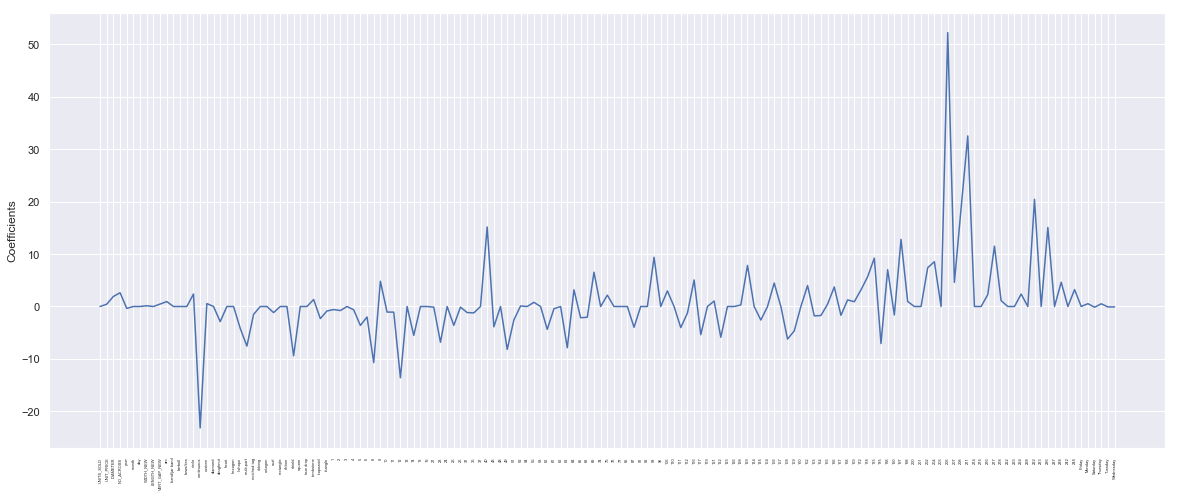

In [41]:
# here's how to plot it
import seaborn as sns
from sklearn.linear_model import Lasso

sns.set()

X = df_new.drop('UNIT_COST', axis=1).values
y = df_new['UNIT_COST'].values
names = df_new.drop('UNIT_COST', axis=1).columns
lasso_coef = best_model_lr.fit(X, y).coef_
_ = plt.figure(figsize=(20, 8))
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=90, fontsize=4)
_ = plt.ylabel('Coefficients')
plt.savefig('coefficients1021.png', dpi=1200)
plt.show()

### 3. Ridge Regression

In [42]:
# Ridge Regression -- fine tuning alpha with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Create the hyperparameter grid
param_grid = {'alpha': np.logspace(-4, 0, 50)}

# Instantiate the Ridge regressor: ridge
ridge = Ridge(normalize=True)

# Setup the GridSearchCV object: ridge_cv
ridge_cv = GridSearchCV(ridge, param_grid, cv=10)

# Fit it to the training data
ridge_cv.fit(X_train, y_train)

# Extract the best estimator
best_model = ridge_cv.best_estimator_

# Predict on the test set and compute metrics
y_pred = best_model.predict(X_test)
ridge_r2 = best_model.score(X_test, y_test)
ridge_mse = mean_squared_error(y_test, y_pred)
print("Tuned Ridge R squared: {}".format(ridge_r2))
print("Tuned Ridge MSE: {}".format(ridge_mse))

Tuned Ridge R squared: 0.8798732095983998
Tuned Ridge MSE: 107.04718860921908


## Ensemble

In [43]:
# specify X, y -- X is UNIT_COST - use sample_new, not sample_new_lr
df_newer = sample_new.copy()
columns = [x for x in df_newer.columns if x != 'UNIT_COST']
X = df_newer[columns]
y = df_newer['UNIT_COST']

# split into test and train
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. Random Forest

In [44]:
# fine-tune with RandomizedSearchCV
# Instantiate a random forests regressor 'rf'
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

# Define the dictionary 'params_rf'
params_rf = {'n_estimators': [25, 100, 350],
             'max_features': ['log2', 'auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4]}

# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Instantiate grid_rf
grid_rf = RandomizedSearchCV(estimator=rf,
                       param_distributions=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       verbose=1,
                       n_jobs=-1)
# Fit 'grid_rf' to the training set
grid_rf.fit(X_train, y_train)
    
# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict on the test set and compute metrics
y_pred = best_model.predict(X_test)
rf_r2 = best_model.score(X_test, y_test)
rf_mse = mean_squared_error(y_test, y_pred)
print("Tuned RandomForest R squared: {}".format(rf_r2))
print("Tuned RandomForest MSE: {}".format(rf_mse))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 39.5min finished


Tuned RandomForest R squared: 0.9964790972108857
Tuned RandomForest MSE: 3.006343223856055


In [45]:
# print best parameters
grid_rf.best_params_

{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 'auto'}

In [46]:
# create predictions dataframe
data = {
        'actual' : y_test,
        'predicted' : y_pred
}
predictions = pd.DataFrame(data)
predictions.head(20)

,actual,predicted
191673,23.678301,22.744944
95794,19.082300,19.493599
1970,32.129799,32.580163
216999,15.619900,13.517795
10144,6.848900,6.962422
129738,10.450800,10.456717
195255,53.007999,50.621339
64785,38.275799,38.241691
91055,10.972400,10.933690
106506,4.199000,4.214913


In [47]:
# save it to excel
predictions.to_excel('regression-predictions.xlsx')

In [44]:
# pickle random forest model
from sklearn.externals import joblib
joblib.dump(best_model, "my_model.pkl")

['my_model.pkl']

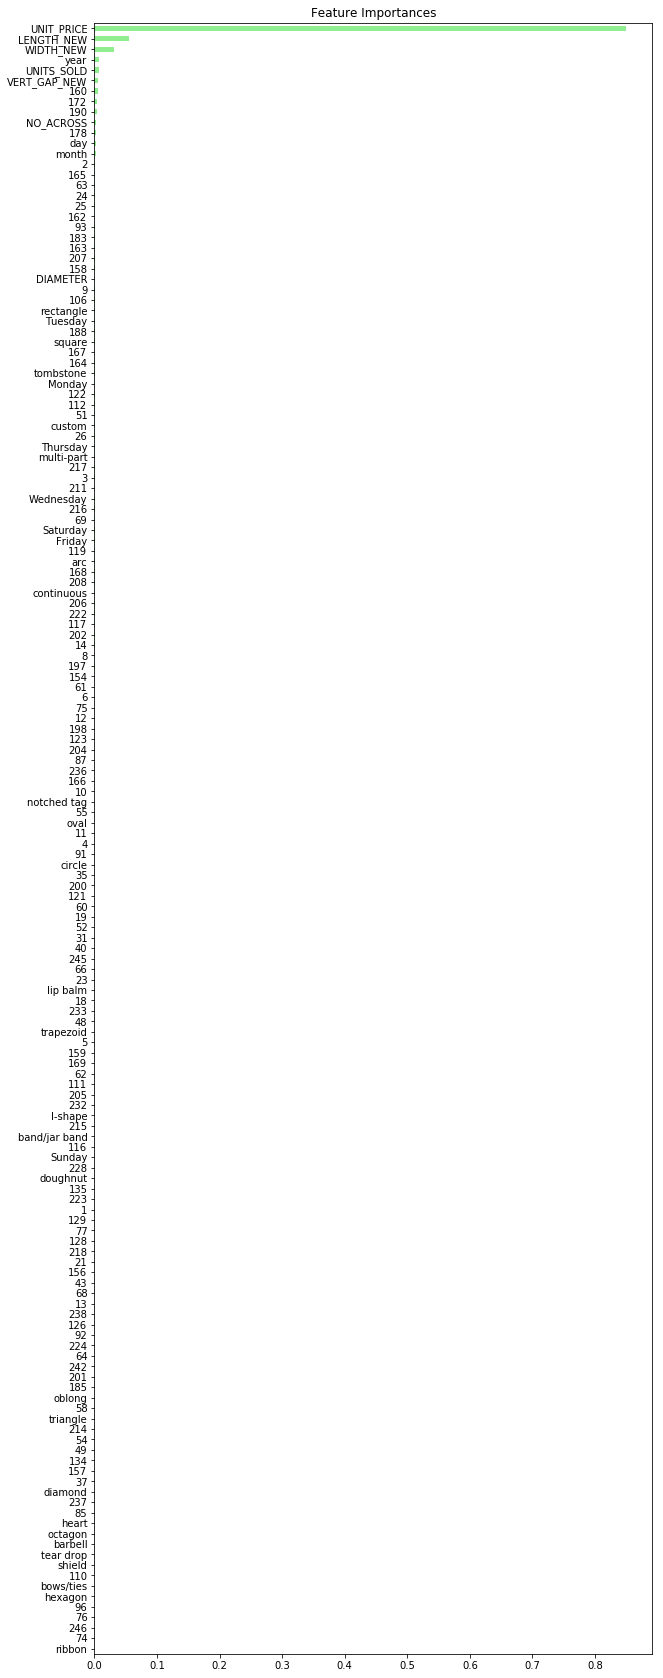

In [42]:
# visualize feature importances

# Create a pd.Series of features importances
importances = pd.Series(data=best_model.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(10, 30))
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Feature Importances')
plt.savefig('feature_importance1021.png', dpi=1200)
plt.show()

Since the high R-squared is suspicious, I will re-run the model using different train-test splits, making smaller tree stubs, and will ask the client for new, unseen data.

In [47]:
# split into test and train
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=43)

# fine-tune with RandomizedSearchCV
# Instantiate a random forests regressor 'rf'
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

# Define the dictionary 'params_rf'
params_rf = {'n_estimators': [25, 100, 350],
             'max_features': ['log2', 'auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4]}

# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Instantiate grid_rf
grid_rf = RandomizedSearchCV(estimator=rf,
                       param_distributions=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       verbose=1,
                       n_jobs=-1)
# Fit 'grid_rf' to the training set
grid_rf.fit(X_train1, y_train1)
    
# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict on the test set and compute metrics
y_pred1 = best_model.predict(X_test1)
rf_r21 = best_model.score(X_test1, y_test1)
rf_mse1 = mean_squared_error(y_test1, y_pred1)
print("Tuned RandomForest R squared: {}".format(rf_r21))
print("Tuned RandomForest MSE: {}".format(rf_mse1))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 37.0min finished


Tuned RandomForest R squared: 0.99656655147518
Tuned RandomForest MSE: 3.0402126009877435


In [48]:
# split into test and train
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=44)

# fine-tune with RandomizedSearchCV
# Instantiate a random forests regressor 'rf'
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

# Define the dictionary 'params_rf'
params_rf = {'n_estimators': [25, 100, 125],
             'max_depth': [10, 20, 30],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [2, 4]}

# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Instantiate grid_rf
grid_rf = RandomizedSearchCV(estimator=rf,
                       param_distributions=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       verbose=1,
                       n_jobs=-1)
# Fit 'grid_rf' to the training set
grid_rf.fit(X_train2, y_train2)
    
# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict on the test set and compute metrics
y_pred2 = best_model.predict(X_test2)
rf_r22 = best_model.score(X_test2, y_test2)
rf_mse2 = mean_squared_error(y_test2, y_pred2)
print("Tuned RandomForest R squared: {}".format(rf_r22))
print("Tuned RandomForest MSE: {}".format(rf_mse2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 22.8min finished


Tuned RandomForest R squared: 0.9911245151259674
Tuned RandomForest MSE: 8.39707344560828


In [49]:
# print best parameters
grid_rf.best_params_

{'n_estimators': 25,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 20}